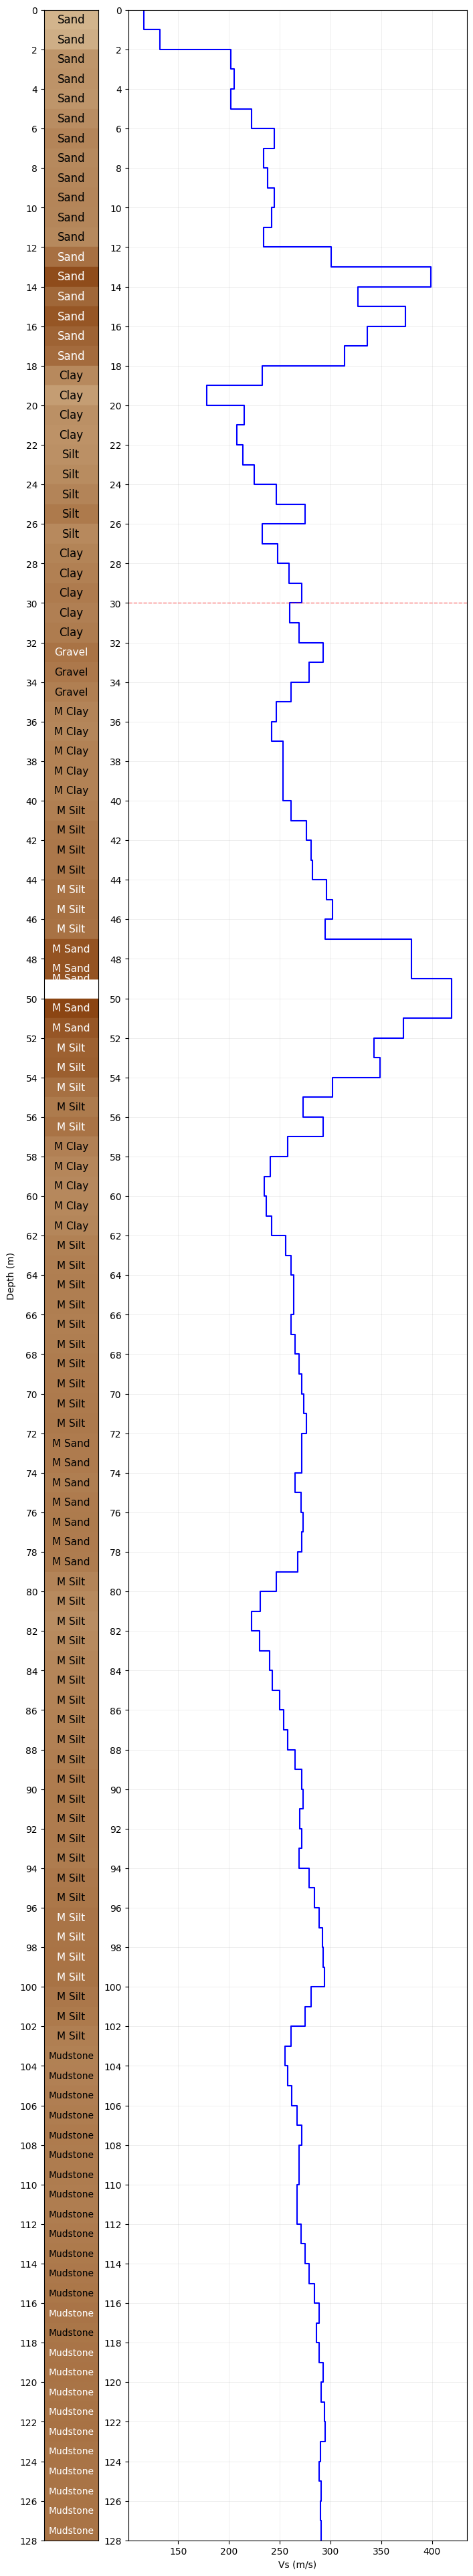

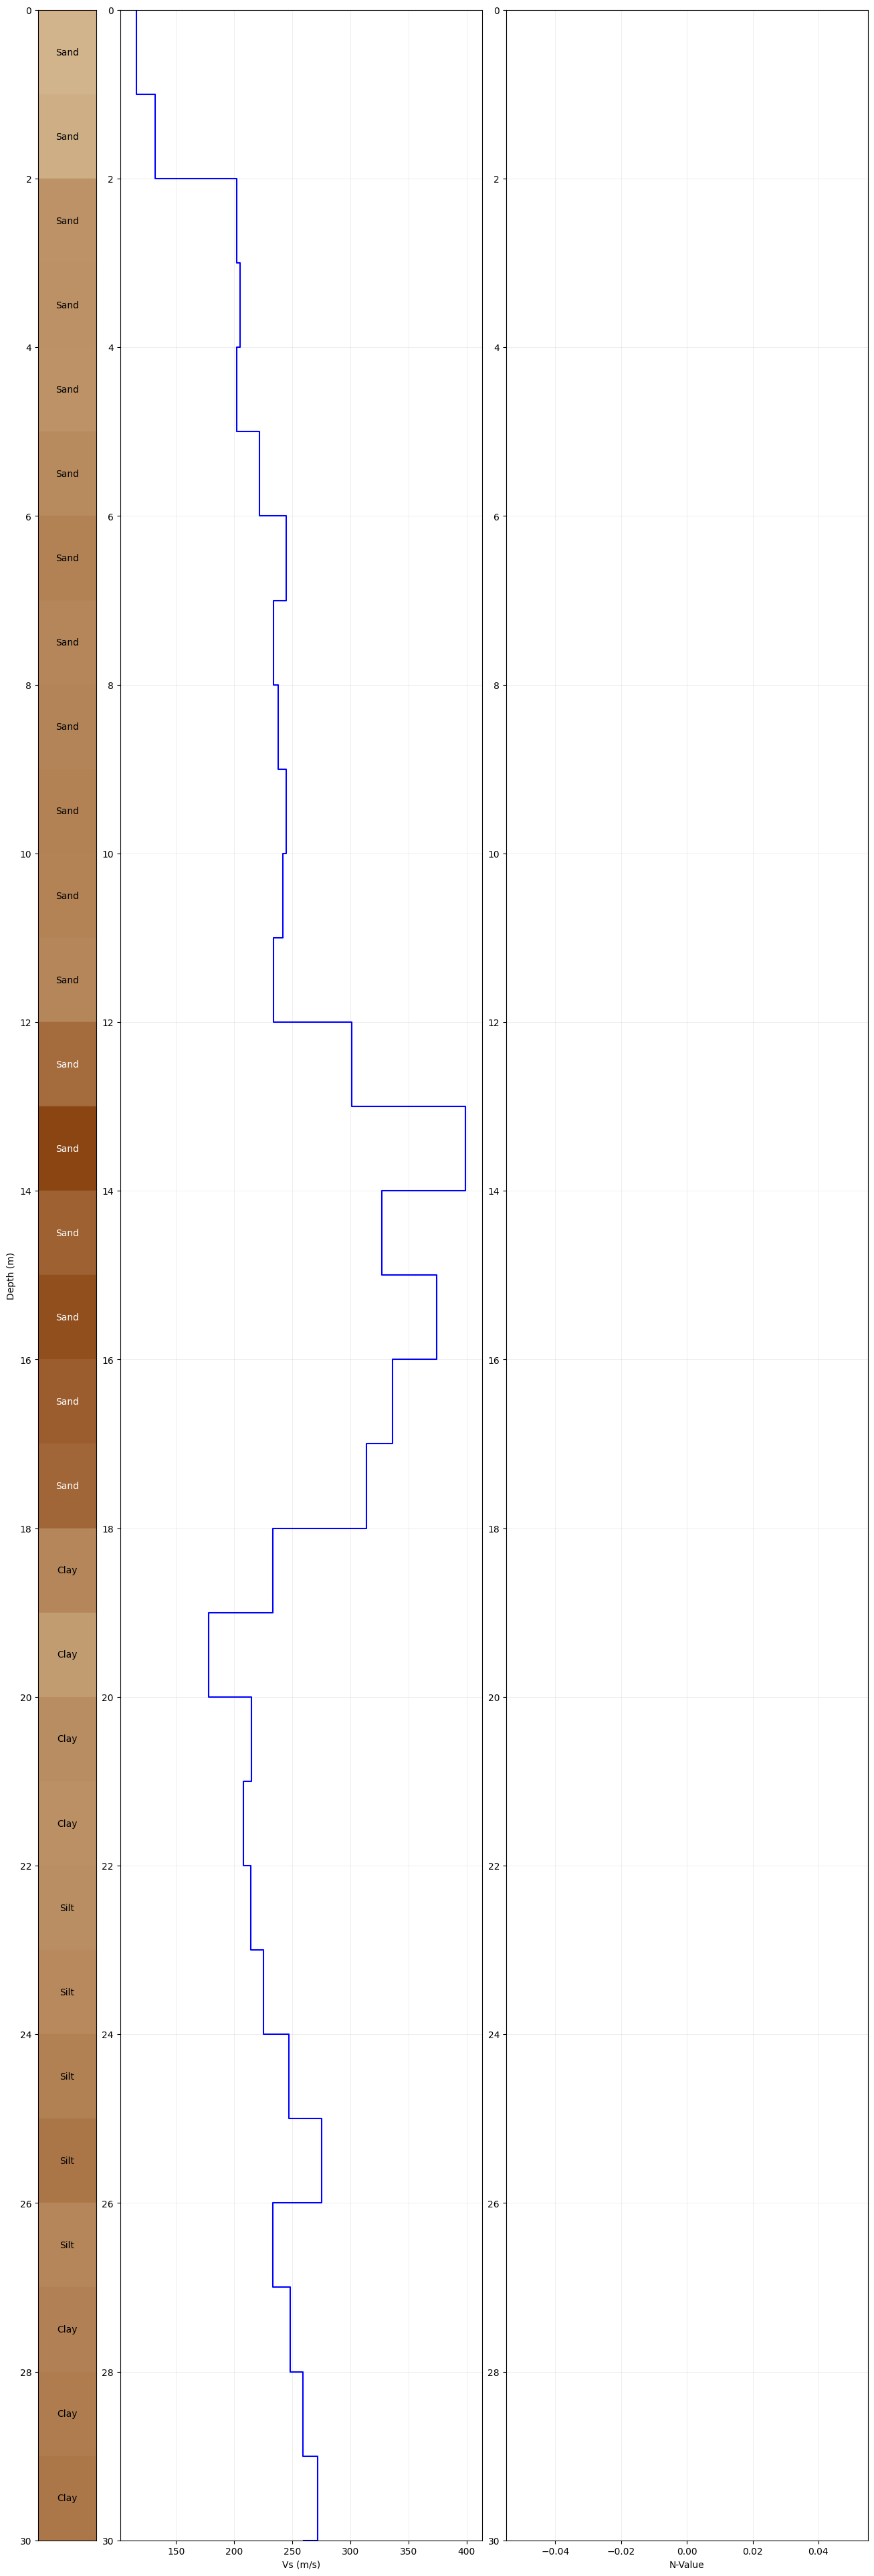

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import csv
from io import StringIO
from collections import OrderedDict

# ─── Replace this with your actual CSV text or filename ───
csv_content = """Layer,Classification,Depth_vs,Vs,Depth_n,N
Layer 1,Sand,0.0,116,,
Layer 1,Sand,1.0,116,,
Layer 2,Sand,1.0,132,,
Layer 2,Sand,2.0,132,,
Layer 3,Sand,2.0,202,,
Layer 3,Sand,3.0,202,,
Layer 4,Sand,3.0,205,,
Layer 4,Sand,4.0,205,,
Layer 5,Sand,4.0,202,,
Layer 5,Sand,5.0,202,,
Layer 6,Sand,5.0,222,,
Layer 6,Sand,6.0,222,,
Layer 7,Sand,6.0,245,,
Layer 7,Sand,7.0,245,,
Layer 8,Sand,7.0,234,,
Layer 8,Sand,8.0,234,,
Layer 9,Sand,8.0,238,,
Layer 9,Sand,9.0,238,,
Layer 10,Sand,9.0,245,,
Layer 10,Sand,10.0,245,,
Layer 11,Sand,10.0,242,,
Layer 11,Sand,11.0,242,,
Layer 12,Sand,11.0,234,,
Layer 12,Sand,12.0,234,,
Layer 13,Sand,12.0,301,,
Layer 13,Sand,13.0,301,,
Layer 14,Sand,13.0,399,,
Layer 14,Sand,14.0,399,,
Layer 15,Sand,14.0,327,,
Layer 15,Sand,15.0,327,,
Layer 16,Sand,15.0,374,,
Layer 16,Sand,16.0,374,,
Layer 17,Sand,16.0,336,,
Layer 17,Sand,17.0,336,,
Layer 18,Sand,17.0,314,,
Layer 18,Sand,18.0,314,,
Layer 19,Clay,18.0,233,,
Layer 19,Clay,19.0,233,,
Layer 20,Clay,19.0,178,,
Layer 20,Clay,20.0,178,,
Layer 21,Clay,20.0,215,,
Layer 21,Clay,21.0,215,,
Layer 22,Clay,21.0,208,,
Layer 22,Clay,22.0,208,,
Layer 23,Silt,22.0,214,,
Layer 23,Silt,23.0,214,,
Layer 24,Silt,23.0,225,,
Layer 24,Silt,24.0,225,,
Layer 25,Silt,24.0,247,,
Layer 25,Silt,25.0,247,,
Layer 26,Silt,25.0,275,,
Layer 26,Silt,26.0,275,,
Layer 27,Silt,26.0,233,,
Layer 27,Silt,27.0,233,,
Layer 28,Clay,27.0,248,,
Layer 28,Clay,28.0,248,,
Layer 29,Clay,28.0,259,,
Layer 29,Clay,29.0,259,,
Layer 30,Clay,29.0,272,,
Layer 30,Clay,30.0,272,,
Layer 31,Clay,30.0,260,,
Layer 31,Clay,31.0,260,,
Layer 32,Clay,31.0,269,,
Layer 32,Clay,32.0,269,,
Layer 33,Gravel,32.0,293,,
Layer 33,Gravel,33.0,293,,
Layer 34,Gravel,33.0,279,,
Layer 34,Gravel,34.0,279,,
Layer 35,Gravel,34.0,261,,
Layer 35,Gravel,35.0,261,,
Layer 36,M Clay,35.0,247,,
Layer 36,M Clay,36.0,247,,
Layer 37,M Clay,36.0,242,,
Layer 37,M Clay,37.0,242,,
Layer 38,M Clay,37.0,253,,
Layer 38,M Clay,38.0,253,,
Layer 39,M Clay,38.0,253,,
Layer 39,M Clay,39.0,253,,
Layer 40,M Clay,39.0,253,,
Layer 40,M Clay,40.0,253,,
Layer 41,M Silt,40.0,261,,
Layer 41,M Silt,41.0,261,,
Layer 42,M Silt,41.0,276,,
Layer 42,M Silt,42.0,276,,
Layer 43,M Silt,42.0,281,,
Layer 43,M Silt,43.0,281,,
Layer 44,M Silt,43.0,282,,
Layer 44,M Silt,44.0,282,,
Layer 45,M Silt,44.0,296,,
Layer 45,M Silt,45.0,296,,
Layer 46,M Silt,45.0,302,,
Layer 46,M Silt,46.0,302,,
Layer 47,M Silt,46.0,295,,
Layer 47,M Silt,47.0,295,,
Layer 48,M Sand,47.0,380,,
Layer 48,M Sand,48.0,380,,
Layer 49,M Sand,48.0,380,,
Layer 49,M Sand,49.0,380,,
Layer 50,M Sand,49.0,388,,
Layer 51,M Sand,50.0,419,,
Layer 51,M Sand,51.0,419,,
Layer 52,M Sand,51.0,372,,
Layer 52,M Sand,52.0,372,,
Layer 53,M Silt,52.0,343,,
Layer 53,M Silt,53.0,343,,
Layer 54,M Silt,53.0,349,,
Layer 54,M Silt,54.0,349,,
Layer 55,M Silt,54.0,302,,
Layer 55,M Silt,55.0,302,,
Layer 56,M Silt,55.0,273,,
Layer 56,M Silt,56.0,273,,
Layer 57,M Silt,56.0,293,,
Layer 57,M Silt,57.0,293,,
Layer 58,M Clay,57.0,258,,
Layer 58,M Clay,58.0,258,,
Layer 59,M Clay,58.0,241,,
Layer 59,M Clay,59.0,241,,
Layer 60,M Clay,59.0,235,,
Layer 60,M Clay,60.0,235,,
Layer 61,M Clay,60.0,237,,
Layer 61,M Clay,61.0,237,,
Layer 62,M Clay,61.0,242,,
Layer 62,M Clay,62.0,242,,
Layer 63,M Silt,62.0,256,,
Layer 63,M Silt,63.0,256,,
Layer 64,M Silt,63.0,261,,
Layer 64,M Silt,64.0,261,,
Layer 65,M Silt,64,264,,
Layer 65,M Silt,65,264,,
Layer 66,M Silt,65,264,,
Layer 66,M Silt,66,264,,
Layer 67,M Silt,66,261,,
Layer 67,M Silt,67,261,,
Layer 68,M Silt,67,265,,
Layer 68,M Silt,68,265,,
Layer 69,M Silt,68,269,,
Layer 69,M Silt,69,269,,
Layer 70,M Silt,69,272,,
Layer 70,M Silt,70,272,,
Layer 71,M Silt,70,274,,
Layer 71,M Silt,71,274,,
Layer 72,M Silt,71,276,,
Layer 72,M Silt,72,276,,
Layer 73,M Sand,72,272,,
Layer 73,M Sand,73,272,,
Layer 74,M Sand,73,272,,
Layer 74,M Sand,74,272,,
Layer 75,M Sand,74,265,,
Layer 75,M Sand,75,265,,
Layer 76,M Sand,75,271,,
Layer 76,M Sand,76,271,,
Layer 77,M Sand,76,273,,
Layer 77,M Sand,77,273,,
Layer 78,M Sand,77,272,,
Layer 78,M Sand,78,272,,
Layer 79,M Sand,78,268,,
Layer 79,M Sand,79,268,,
Layer 80,M Silt,79,247,,
Layer 80,M Silt,80,247,,
Layer 81,M Silt,80,231,,
Layer 81,M Silt,81,231,,
Layer 82,M Silt,81,222,,
Layer 82,M Silt,82,222,,
Layer 83,M Silt,82,230,,
Layer 83,M Silt,83,230,,
Layer 84,M Silt,83,240,,
Layer 84,M Silt,84,240,,
Layer 85,M Silt,84,243,,
Layer 85,M Silt,85,243,,
Layer 86,M Silt,85,250,,
Layer 86,M Silt,86,250,,
Layer 87,M Silt,86,254,,
Layer 87,M Silt,87,254,,
Layer 88,M Silt,87,258,,
Layer 88,M Silt,88,258,,
Layer 89,M Silt,88,265,,
Layer 89,M Silt,89,265,,
Layer 90,M Silt,89,272,,
Layer 90,M Silt,90,272,,
Layer 91,M Silt,90,273,,
Layer 91,M Silt,91,273,,
Layer 92,M Silt,91,270,,
Layer 92,M Silt,92,270,,
Layer 93,M Silt,92,272,,
Layer 93,M Silt,93,272,,
Layer 94,M Silt,93,269,,
Layer 94,M Silt,94,269,,
Layer 95,M Silt,94,279,,
Layer 95,M Silt,95,279,,
Layer 96,M Silt,95,284,,
Layer 96,M Silt,96,284,,
Layer 97,M Silt,96,289,,
Layer 97,M Silt,97,289,,
Layer 98,M Silt,97,292,,
Layer 98,M Silt,98,292,,
Layer 99,M Silt,98,293,,
Layer 99,M Silt,99,293,,
Layer 100,M Silt,99,294,,
Layer 100,M Silt,100,294,,
Layer 101,M Silt,100,281,,
Layer 101,M Silt,101,281,,
Layer 102,M Silt,101,275,,
Layer 102,M Silt,102,275,,
Layer 103,M Silt,102,261,,
Layer 103,M Silt,103,261,,
Layer 104,Mudstone,103,255,,
Layer 104,Mudstone,104,255,,
Layer 105,Mudstone,104,258,,
Layer 105,Mudstone,105,258,,
Layer 106,Mudstone,105,262,,
Layer 106,Mudstone,106,262,,
Layer 107,Mudstone,106,267,,
Layer 107,Mudstone,107,267,,
Layer 108,Mudstone,107,272,,
Layer 108,Mudstone,108,272,,
Layer 109,Mudstone,108,269,,
Layer 109,Mudstone,109,269,,
Layer 110,Mudstone,109,269,,
Layer 110,Mudstone,110,269,,
Layer 111,Mudstone,110,267,,
Layer 111,Mudstone,111,267,,
Layer 112,Mudstone,111,267,,
Layer 112,Mudstone,112,267,,
Layer 113,Mudstone,112,271,,
Layer 113,Mudstone,113,271,,
Layer 114,Mudstone,113,275,,
Layer 114,Mudstone,114,275,,
Layer 115,Mudstone,114,279,,
Layer 115,Mudstone,115,279,,
Layer 116,Mudstone,115,284,,
Layer 116,Mudstone,116,284,,
Layer 117,Mudstone,116,289,,
Layer 117,Mudstone,117,289,,
Layer 118,Mudstone,117,286,,
Layer 118,Mudstone,118,286,,
Layer 119,Mudstone,118,289,,
Layer 119,Mudstone,119,289,,
Layer 120,Mudstone,119,293,,
Layer 120,Mudstone,120,293,,
Layer 121,Mudstone,120,291,,
Layer 121,Mudstone,121,291,,
Layer 122,Mudstone,121,294,,
Layer 122,Mudstone,122,294,,
Layer 123,Mudstone,122,295,,
Layer 123,Mudstone,123,295,,
Layer 124,Mudstone,123,290,,
Layer 124,Mudstone,124,290,,
Layer 125,Mudstone,124,289,,
Layer 125,Mudstone,125,289,,
Layer 126,Mudstone,125,291,,
Layer 126,Mudstone,126,291,,
Layer 127,Mudstone,126,290,,
Layer 127,Mudstone,127,290,,
Layer 128,Mudstone,127,291,,
Layer 128,Mudstone,128,291,,
"""

def get_contrast_text_color(rgb):
    brightness = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return "white" if brightness < 0.5 else "black"

def plot_layer_classification(ax, boundaries, labels, vs_vals):
    norm = mcolors.Normalize(min(vs_vals), max(vs_vals))
    cmap = LinearSegmentedColormap.from_list("brown_shades", ["#d2b48c", "#8B4513"])
    # determine dynamic font sizes
    max_label_len = max(len(lbl) for lbl in labels)
    min_fs, max_fs = 10, 14
    for (top, bot), cls, vs in zip(boundaries, labels, vs_vals):
        color = cmap(norm(vs))
        ax.fill_betweenx([top, bot], 0, 1, color=color)
        mid = (top + bot) / 2
        # scale font size: longer labels get closer to min_fs, shorter closer to max_fs
        fs = max_fs - (len(cls)/max_label_len) * (max_fs - min_fs)
        ax.text(0.5, mid, cls,
                ha='center', va='center',
                color=get_contrast_text_color(color),
                fontsize=fs)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel("Depth (m)")

def plot_shearwave_velocity(ax, depth, vs):
    ax.step(vs, depth, where='post', color='blue')
    ax.set_xlabel("Vs (m/s)")
    ax.grid(True, linewidth=0.5, alpha=0.3)

def plot_n_values(ax, depth, nvals):
    ax.step(nvals, depth, where='post', color='blue')
    ax.set_xlabel("N-Value")
    ax.grid(True, linewidth=0.5, alpha=0.3)

    xmin, xmax = ax.get_xlim()
    x_range = xmax - xmin
    margin = x_range * 0.05  # keep labels at least 5% away from each vertical edge

    i = 0
    while i < len(nvals):
        if nvals[i] >= 50:
            # find end of this contiguous refusal block
            j = i
            while j + 1 < len(nvals) and nvals[j + 1] >= 50:
                j += 1

            x_pt, y_pt = nvals[j], depth[j]
            # decide whether to offset left or right
            if x_pt + margin > xmax:
                offset_x, ha = -5, 'right'
            else:
                offset_x, ha = 5, 'left'

            # annotate just above the line, clipped inside axes
            ax.annotate(
                "Refusal",
                xy=(x_pt, y_pt),
                xytext=(offset_x, 5),         # x,y offset in points (→,↑)
                textcoords='offset points',
                ha=ha, va='bottom',
                fontsize=10,
                backgroundcolor='white',
                alpha=0.7,
                clip_on=True
            )
            i = j + 1
        else:
            i += 1


def truncate_profile(depth, vs, cutoff):
    d2, v2 = [], []
    for d, v in zip(depth, vs):
        if d <= cutoff:
            d2.append(d); v2.append(v)
        else:
            break
    return d2, v2

def main():
    # Read CSV
    f = StringIO(csv_content)
    reader = csv.DictReader(f)
    rows = [r for r in reader if r["Layer"] and not r["Layer"].startswith("#")]

    # Vs series
    depth_vs_all = [float(r["Depth_vs"]) for r in rows]
    vs_all       = [float(r["Vs"])        for r in rows]

    # N series (skip blanks)
    depth_n_all, n_all = [], []
    for r in rows:
        dn, nn = r["Depth_n"].strip(), r["N"].strip()
        if dn and nn:
            depth_n_all.append(float(dn))
            n_all.append(float(nn))

    # Group by layer to get intervals & Vs per layer
    groups = OrderedDict()
    for r in rows:
        L = r["Layer"]
        if L not in groups:
            groups[L] = {"classification": r["Classification"],
                         "depth_vs": [], "vs": []}
        groups[L]["depth_vs"].append(float(r["Depth_vs"]))
        groups[L]["vs"].append(float(r["Vs"]))

    # Build boundaries, labels, Vs-values
    layer_boundaries = []
    layer_vs_values  = []
    layer_classifs   = []
    for g in groups.values():
        dv = sorted(g["depth_vs"])
        top, bot = dv[0], dv[-1]
        layer_boundaries.append((top, bot))
        layer_vs_values.append(g["vs"][0])
        layer_classifs.append(g["classification"])

    # Determine overall depth range & ticks
    overall_top    = layer_boundaries[0][0]
    overall_bottom = layer_boundaries[-1][1]
    yticks = np.arange(overall_top, overall_bottom + 1, 2)

    # # Dynamically size height by layer count
    # n_layers     = len(layer_boundaries)
    # block_height = 0.5  # inches per layer
    # min_height   = 6    # minimum figure height
    # fig_height   = max(min_height, n_layers * block_height)

    # Dynamically size height by depth
    depth_range   = overall_bottom - overall_top      # total metres
    inch_per_m    = 0.3                              # inches per metre
    min_height    = 6                                # minimum figure height
    fig_height    = max(min_height, depth_range * inch_per_m)


    # Find max label length to size classification axis
    max_label_len = max(len(lbl) for lbl in layer_classifs)
    char_width    = 0.12  # inches per character estimate
    class_width   = max_label_len * char_width
    other_width   = 6     # inches for each of the other plots

    # Engineering bedrock detection
    max_vs       = max(vs_all)
    max_vs_depth = depth_vs_all[vs_all.index(max_vs)]
    eng_bedrock  = next((t for t, b in layer_boundaries if t <= max_vs_depth < b), None)

    # Figure 1: classification + Vs (+ N if available)
    if depth_n_all:
        total_width = class_width + 2*other_width
        fig = plt.figure(figsize=(total_width, fig_height), constrained_layout=True)
        gs = fig.add_gridspec(1, 3, width_ratios=[class_width, other_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[0,2])
    else:
        total_width = class_width + other_width
        fig = plt.figure(figsize=(total_width, fig_height), constrained_layout=True)
        gs = fig.add_gridspec(1, 2, width_ratios=[class_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = None

    plot_layer_classification(ax1, layer_boundaries, layer_classifs, layer_vs_values)
    plot_shearwave_velocity   (ax2, depth_vs_all, vs_all)
    # draw 30m line in red only if profile reaches 30m
    if overall_bottom >= 30:
        ax2.axhline(30, color='red', linestyle='--', linewidth=1.0, alpha=0.5)
    if ax3:
        plot_n_values(ax3, depth_n_all, n_all)

    # Apply uniform y-axis to all subplots
    for ax in [ax1, ax2] + ([ax3] if ax3 else []):
        ax.set_ylim(overall_bottom, overall_top)
        ax.set_yticks(yticks)

    plt.show()

    # # Figure 2: Vs truncated at bedrock
    # if eng_bedrock is not None:
    #     td, tv = truncate_profile(depth_vs_all, vs_all, eng_bedrock)
    # else:
    #     td, tv = depth_vs_all, vs_all

    # fig2, ax4 = plt.subplots(figsize=(other_width, fig_height), constrained_layout=True)
    # plot_shearwave_velocity(ax4, td, tv)
    # # draw 30m line in red only if profile reaches 30m
    # if overall_bottom >= 30:
    #     ax4.axhline(30, color='red', linestyle='--', linewidth=1.0, alpha=0.5)

    # ax4.set_ylabel("Depth (m)")
    # ax4.set_ylim(overall_bottom, overall_top)
    # ax4.set_yticks(yticks)
    # if eng_bedrock is not None:
    #     ax4.axhline(eng_bedrock, color='red', linestyle='--',
    #                 label=f"Bedrock ({max_vs:.1f} m/s)")
    #     ax4.legend()

    # plt.show()

    # ─── Figure 3: classification + Vs + N up to 30 m ───

    # 1) Truncate your raw depth/series at 30 m
    depth_vs30, vs30 = truncate_profile(depth_vs_all, vs_all, 30)
    depth_n30,  n30  = truncate_profile(depth_n_all,   n_all,   30)

    # 2) Clip each layer‐block so it doesn’t exceed 30 m
    clipped_bounds30 = []
    clipped_clfs30   = []
    clipped_vsv30    = []
    for (top, bot), cls, vs in zip(layer_boundaries,
                                  layer_classifs,
                                  layer_vs_values):
        if top < 30:
            clipped_bounds30.append((top, min(bot, 30)))
            clipped_clfs30.append(cls)
            clipped_vsv30.append(vs)

    # 3) Build the 1×3 grid just like Fig.1
    fig3 = plt.figure(
        figsize=(class_width + 2*other_width, fig_height),
        constrained_layout=True
    )
    gs3 = fig3.add_gridspec(1, 3,
                             width_ratios=[class_width,
                                           other_width,
                                           other_width])
    ax1 = fig3.add_subplot(gs3[0,0])
    ax2 = fig3.add_subplot(gs3[0,1])
    ax3 = fig3.add_subplot(gs3[0,2])

    # 4) Plot
    plot_layer_classification(ax1,
                              clipped_bounds30,
                              clipped_clfs30,
                              clipped_vsv30)
    plot_shearwave_velocity   (ax2, depth_vs30, vs30)
    plot_n_values             (ax3, depth_n30,  n30)

    # 5) Invert & limit Y to 0→30 m, ticks every 2 m
    for ax in (ax1, ax2, ax3):
        ax.set_ylim(30, 0)
        ax.set_yticks(np.arange(0, 31, 2))

    plt.show()


if __name__ == "__main__":
    main()


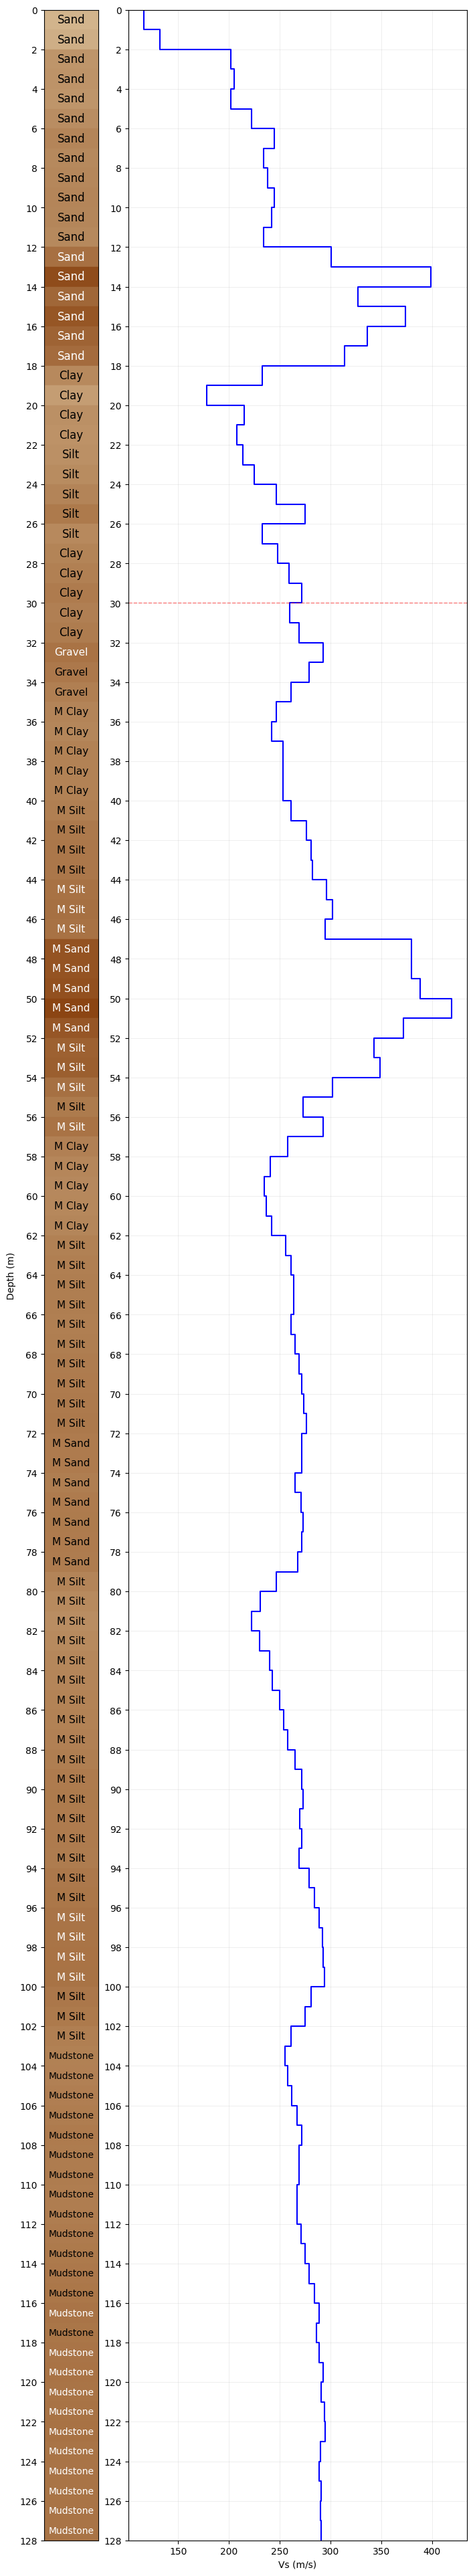

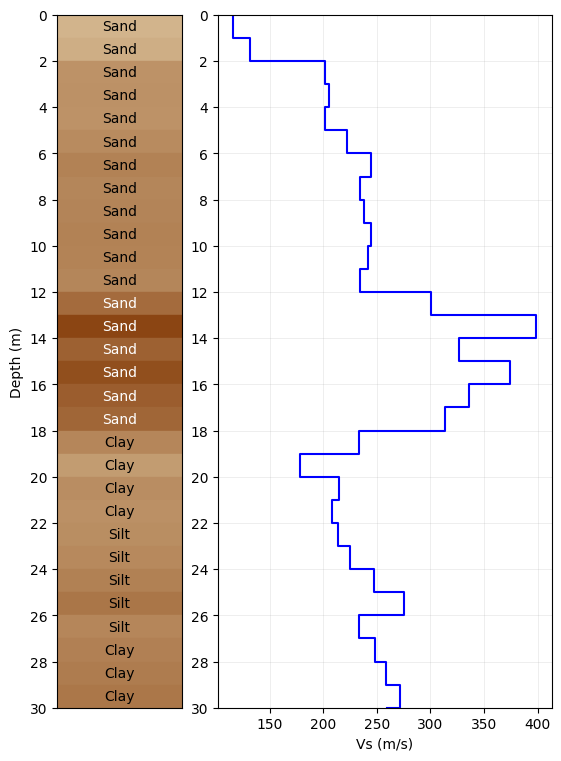

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import csv
from io import StringIO
from collections import OrderedDict

# ─── Replace this with your actual CSV text or filename ───
csv_content = """Layer,Classification,Depth_vs,Vs,Depth_n,N
Layer 1,Sand,0.0,116,,
Layer 1,Sand,1.0,116,,
Layer 2,Sand,1.0,132,,
Layer 2,Sand,2.0,132,,
Layer 3,Sand,2.0,202,,
Layer 3,Sand,3.0,202,,
Layer 4,Sand,3.0,205,,
Layer 4,Sand,4.0,205,,
Layer 5,Sand,4.0,202,,
Layer 5,Sand,5.0,202,,
Layer 6,Sand,5.0,222,,
Layer 6,Sand,6.0,222,,
Layer 7,Sand,6.0,245,,
Layer 7,Sand,7.0,245,,
Layer 8,Sand,7.0,234,,
Layer 8,Sand,8.0,234,,
Layer 9,Sand,8.0,238,,
Layer 9,Sand,9.0,238,,
Layer 10,Sand,9.0,245,,
Layer 10,Sand,10.0,245,,
Layer 11,Sand,10.0,242,,
Layer 11,Sand,11.0,242,,
Layer 12,Sand,11.0,234,,
Layer 12,Sand,12.0,234,,
Layer 13,Sand,12.0,301,,
Layer 13,Sand,13.0,301,,
Layer 14,Sand,13.0,399,,
Layer 14,Sand,14.0,399,,
Layer 15,Sand,14.0,327,,
Layer 15,Sand,15.0,327,,
Layer 16,Sand,15.0,374,,
Layer 16,Sand,16.0,374,,
Layer 17,Sand,16.0,336,,
Layer 17,Sand,17.0,336,,
Layer 18,Sand,17.0,314,,
Layer 18,Sand,18.0,314,,
Layer 19,Clay,18.0,233,,
Layer 19,Clay,19.0,233,,
Layer 20,Clay,19.0,178,,
Layer 20,Clay,20.0,178,,
Layer 21,Clay,20.0,215,,
Layer 21,Clay,21.0,215,,
Layer 22,Clay,21.0,208,,
Layer 22,Clay,22.0,208,,
Layer 23,Silt,22.0,214,,
Layer 23,Silt,23.0,214,,
Layer 24,Silt,23.0,225,,
Layer 24,Silt,24.0,225,,
Layer 25,Silt,24.0,247,,
Layer 25,Silt,25.0,247,,
Layer 26,Silt,25.0,275,,
Layer 26,Silt,26.0,275,,
Layer 27,Silt,26.0,233,,
Layer 27,Silt,27.0,233,,
Layer 28,Clay,27.0,248,,
Layer 28,Clay,28.0,248,,
Layer 29,Clay,28.0,259,,
Layer 29,Clay,29.0,259,,
Layer 30,Clay,29.0,272,,
Layer 30,Clay,30.0,272,,
Layer 31,Clay,30.0,260,,
Layer 31,Clay,31.0,260,,
Layer 32,Clay,31.0,269,,
Layer 32,Clay,32.0,269,,
Layer 33,Gravel,32.0,293,,
Layer 33,Gravel,33.0,293,,
Layer 34,Gravel,33.0,279,,
Layer 34,Gravel,34.0,279,,
Layer 35,Gravel,34.0,261,,
Layer 35,Gravel,35.0,261,,
Layer 36,M Clay,35.0,247,,
Layer 36,M Clay,36.0,247,,
Layer 37,M Clay,36.0,242,,
Layer 37,M Clay,37.0,242,,
Layer 38,M Clay,37.0,253,,
Layer 38,M Clay,38.0,253,,
Layer 39,M Clay,38.0,253,,
Layer 39,M Clay,39.0,253,,
Layer 40,M Clay,39.0,253,,
Layer 40,M Clay,40.0,253,,
Layer 41,M Silt,40.0,261,,
Layer 41,M Silt,41.0,261,,
Layer 42,M Silt,41.0,276,,
Layer 42,M Silt,42.0,276,,
Layer 43,M Silt,42.0,281,,
Layer 43,M Silt,43.0,281,,
Layer 44,M Silt,43.0,282,,
Layer 44,M Silt,44.0,282,,
Layer 45,M Silt,44.0,296,,
Layer 45,M Silt,45.0,296,,
Layer 46,M Silt,45.0,302,,
Layer 46,M Silt,46.0,302,,
Layer 47,M Silt,46.0,295,,
Layer 47,M Silt,47.0,295,,
Layer 48,M Sand,47.0,380,,
Layer 48,M Sand,48.0,380,,
Layer 49,M Sand,48.0,380,,
Layer 49,M Sand,49.0,380,,
Layer 50,M Sand,49.0,388,,
Layer 50,M Sand,50.0,388,,
Layer 51,M Sand,50.0,419,,
Layer 51,M Sand,51.0,419,,
Layer 52,M Sand,51.0,372,,
Layer 52,M Sand,52.0,372,,
Layer 53,M Silt,52.0,343,,
Layer 53,M Silt,53.0,343,,
Layer 54,M Silt,53.0,349,,
Layer 54,M Silt,54.0,349,,
Layer 55,M Silt,54.0,302,,
Layer 55,M Silt,55.0,302,,
Layer 56,M Silt,55.0,273,,
Layer 56,M Silt,56.0,273,,
Layer 57,M Silt,56.0,293,,
Layer 57,M Silt,57.0,293,,
Layer 58,M Clay,57.0,258,,
Layer 58,M Clay,58.0,258,,
Layer 59,M Clay,58.0,241,,
Layer 59,M Clay,59.0,241,,
Layer 60,M Clay,59.0,235,,
Layer 60,M Clay,60.0,235,,
Layer 61,M Clay,60.0,237,,
Layer 61,M Clay,61.0,237,,
Layer 62,M Clay,61.0,242,,
Layer 62,M Clay,62.0,242,,
Layer 63,M Silt,62.0,256,,
Layer 63,M Silt,63.0,256,,
Layer 64,M Silt,63.0,261,,
Layer 64,M Silt,64.0,261,,
Layer 65,M Silt,64,264,,
Layer 65,M Silt,65,264,,
Layer 66,M Silt,65,264,,
Layer 66,M Silt,66,264,,
Layer 67,M Silt,66,261,,
Layer 67,M Silt,67,261,,
Layer 68,M Silt,67,265,,
Layer 68,M Silt,68,265,,
Layer 69,M Silt,68,269,,
Layer 69,M Silt,69,269,,
Layer 70,M Silt,69,272,,
Layer 70,M Silt,70,272,,
Layer 71,M Silt,70,274,,
Layer 71,M Silt,71,274,,
Layer 72,M Silt,71,276,,
Layer 72,M Silt,72,276,,
Layer 73,M Sand,72,272,,
Layer 73,M Sand,73,272,,
Layer 74,M Sand,73,272,,
Layer 74,M Sand,74,272,,
Layer 75,M Sand,74,265,,
Layer 75,M Sand,75,265,,
Layer 76,M Sand,75,271,,
Layer 76,M Sand,76,271,,
Layer 77,M Sand,76,273,,
Layer 77,M Sand,77,273,,
Layer 78,M Sand,77,272,,
Layer 78,M Sand,78,272,,
Layer 79,M Sand,78,268,,
Layer 79,M Sand,79,268,,
Layer 80,M Silt,79,247,,
Layer 80,M Silt,80,247,,
Layer 81,M Silt,80,231,,
Layer 81,M Silt,81,231,,
Layer 82,M Silt,81,222,,
Layer 82,M Silt,82,222,,
Layer 83,M Silt,82,230,,
Layer 83,M Silt,83,230,,
Layer 84,M Silt,83,240,,
Layer 84,M Silt,84,240,,
Layer 85,M Silt,84,243,,
Layer 85,M Silt,85,243,,
Layer 86,M Silt,85,250,,
Layer 86,M Silt,86,250,,
Layer 87,M Silt,86,254,,
Layer 87,M Silt,87,254,,
Layer 88,M Silt,87,258,,
Layer 88,M Silt,88,258,,
Layer 89,M Silt,88,265,,
Layer 89,M Silt,89,265,,
Layer 90,M Silt,89,272,,
Layer 90,M Silt,90,272,,
Layer 91,M Silt,90,273,,
Layer 91,M Silt,91,273,,
Layer 92,M Silt,91,270,,
Layer 92,M Silt,92,270,,
Layer 93,M Silt,92,272,,
Layer 93,M Silt,93,272,,
Layer 94,M Silt,93,269,,
Layer 94,M Silt,94,269,,
Layer 95,M Silt,94,279,,
Layer 95,M Silt,95,279,,
Layer 96,M Silt,95,284,,
Layer 96,M Silt,96,284,,
Layer 97,M Silt,96,289,,
Layer 97,M Silt,97,289,,
Layer 98,M Silt,97,292,,
Layer 98,M Silt,98,292,,
Layer 99,M Silt,98,293,,
Layer 99,M Silt,99,293,,
Layer 100,M Silt,99,294,,
Layer 100,M Silt,100,294,,
Layer 101,M Silt,100,281,,
Layer 101,M Silt,101,281,,
Layer 102,M Silt,101,275,,
Layer 102,M Silt,102,275,,
Layer 103,M Silt,102,261,,
Layer 103,M Silt,103,261,,
Layer 104,Mudstone,103,255,,
Layer 104,Mudstone,104,255,,
Layer 105,Mudstone,104,258,,
Layer 105,Mudstone,105,258,,
Layer 106,Mudstone,105,262,,
Layer 106,Mudstone,106,262,,
Layer 107,Mudstone,106,267,,
Layer 107,Mudstone,107,267,,
Layer 108,Mudstone,107,272,,
Layer 108,Mudstone,108,272,,
Layer 109,Mudstone,108,269,,
Layer 109,Mudstone,109,269,,
Layer 110,Mudstone,109,269,,
Layer 110,Mudstone,110,269,,
Layer 111,Mudstone,110,267,,
Layer 111,Mudstone,111,267,,
Layer 112,Mudstone,111,267,,
Layer 112,Mudstone,112,267,,
Layer 113,Mudstone,112,271,,
Layer 113,Mudstone,113,271,,
Layer 114,Mudstone,113,275,,
Layer 114,Mudstone,114,275,,
Layer 115,Mudstone,114,279,,
Layer 115,Mudstone,115,279,,
Layer 116,Mudstone,115,284,,
Layer 116,Mudstone,116,284,,
Layer 117,Mudstone,116,289,,
Layer 117,Mudstone,117,289,,
Layer 118,Mudstone,117,286,,
Layer 118,Mudstone,118,286,,
Layer 119,Mudstone,118,289,,
Layer 119,Mudstone,119,289,,
Layer 120,Mudstone,119,293,,
Layer 120,Mudstone,120,293,,
Layer 121,Mudstone,120,291,,
Layer 121,Mudstone,121,291,,
Layer 122,Mudstone,121,294,,
Layer 122,Mudstone,122,294,,
Layer 123,Mudstone,122,295,,
Layer 123,Mudstone,123,295,,
Layer 124,Mudstone,123,290,,
Layer 124,Mudstone,124,290,,
Layer 125,Mudstone,124,289,,
Layer 125,Mudstone,125,289,,
Layer 126,Mudstone,125,291,,
Layer 126,Mudstone,126,291,,
Layer 127,Mudstone,126,290,,
Layer 127,Mudstone,127,290,,
Layer 128,Mudstone,127,291,,
Layer 128,Mudstone,128,291,,
"""

def get_contrast_text_color(rgb):
    brightness = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return "white" if brightness < 0.5 else "black"

def plot_layer_classification(ax, boundaries, labels, vs_vals):
    norm = mcolors.Normalize(min(vs_vals), max(vs_vals))
    cmap = LinearSegmentedColormap.from_list("brown_shades", ["#d2b48c", "#8B4513"])
    # determine dynamic font sizes
    max_label_len = max(len(lbl) for lbl in labels)
    min_fs, max_fs = 10, 14
    for (top, bot), cls, vs in zip(boundaries, labels, vs_vals):
        color = cmap(norm(vs))
        ax.fill_betweenx([top, bot], 0, 1, color=color)
        mid = (top + bot) / 2
        # scale font size: longer labels get closer to min_fs, shorter closer to max_fs
        fs = max_fs - (len(cls)/max_label_len) * (max_fs - min_fs)
        ax.text(0.5, mid, cls,
                ha='center', va='center',
                color=get_contrast_text_color(color),
                fontsize=fs)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel("Depth (m)")

def plot_shearwave_velocity(ax, depth, vs):
    ax.step(vs, depth, where='post', color='blue')
    ax.set_xlabel("Vs (m/s)")
    ax.grid(True, linewidth=0.5, alpha=0.3)

def plot_n_values(ax, depth, nvals):
    ax.step(nvals, depth, where='post', color='blue')
    ax.set_xlabel("N-Value")
    ax.grid(True, linewidth=0.5, alpha=0.3)

    xmin, xmax = ax.get_xlim()
    x_range = xmax - xmin
    margin = x_range * 0.05  # keep labels at least 5% away from each vertical edge

    i = 0
    while i < len(nvals):
        if nvals[i] >= 50:
            # find end of this contiguous refusal block
            j = i
            while j + 1 < len(nvals) and nvals[j + 1] >= 50:
                j += 1

            x_pt, y_pt = nvals[j], depth[j]
            # decide whether to offset left or right
            if x_pt + margin > xmax:
                offset_x, ha = -5, 'right'
            else:
                offset_x, ha = 5, 'left'

            # annotate just above the line, clipped inside axes
            ax.annotate(
                "Refusal",
                xy=(x_pt, y_pt),
                xytext=(offset_x, 5),         # x,y offset in points (→,↑)
                textcoords='offset points',
                ha=ha, va='bottom',
                fontsize=10,
                backgroundcolor='white',
                alpha=0.7,
                clip_on=True
            )
            i = j + 1
        else:
            i += 1


def truncate_profile(depth, vs, cutoff):
    d2, v2 = [], []
    for d, v in zip(depth, vs):
        if d <= cutoff:
            d2.append(d); v2.append(v)
        else:
            break
    return d2, v2

def main():
    # Read CSV
    f = StringIO(csv_content)
    reader = csv.DictReader(f)
    rows = [r for r in reader if r["Layer"] and not r["Layer"].startswith("#")]

    # Vs series
    depth_vs_all = [float(r["Depth_vs"]) for r in rows]
    vs_all       = [float(r["Vs"])        for r in rows]

    # N series (skip blanks)
    depth_n_all, n_all = [], []
    for r in rows:
        dn, nn = r["Depth_n"].strip(), r["N"].strip()
        if dn and nn:
            depth_n_all.append(float(dn))
            n_all.append(float(nn))

    # Group by layer to get intervals & Vs per layer
    groups = OrderedDict()
    for r in rows:
        L = r["Layer"]
        if L not in groups:
            groups[L] = {"classification": r["Classification"],
                         "depth_vs": [], "vs": []}
        groups[L]["depth_vs"].append(float(r["Depth_vs"]))
        groups[L]["vs"].append(float(r["Vs"]))

    # Build boundaries, labels, Vs-values
    layer_boundaries = []
    layer_vs_values  = []
    layer_classifs   = []
    for g in groups.values():
        dv = sorted(g["depth_vs"])
        top, bot = dv[0], dv[-1]
        layer_boundaries.append((top, bot))
        layer_vs_values.append(g["vs"][0])
        layer_classifs.append(g["classification"])

    # Determine overall depth range & ticks
    overall_top    = layer_boundaries[0][0]
    overall_bottom = layer_boundaries[-1][1]
    yticks = np.arange(overall_top, overall_bottom + 1, 2)

    # # Dynamically size height by layer count
    # n_layers     = len(layer_boundaries)
    # block_height = 0.5  # inches per layer
    # min_height   = 6    # minimum figure height
    # fig_height   = max(min_height, n_layers * block_height)

    # Dynamically size height by depth
    depth_range   = overall_bottom - overall_top      # total metres
    inch_per_m    = 0.3                              # inches per metre
    min_height    = 6                                # minimum figure height
    fig_height    = max(min_height, depth_range * inch_per_m)


    # Find max label length to size classification axis
    max_label_len = max(len(lbl) for lbl in layer_classifs)
    char_width    = 0.12  # inches per character estimate
    class_width   = max_label_len * char_width
    other_width   = 6     # inches for each of the other plots

    # Engineering bedrock detection
    max_vs       = max(vs_all)
    max_vs_depth = depth_vs_all[vs_all.index(max_vs)]
    eng_bedrock  = next((t for t, b in layer_boundaries if t <= max_vs_depth < b), None)

    # Figure 1: classification + Vs (+ N if available)
    if depth_n_all:
        total_width = class_width + 2*other_width
        fig = plt.figure(figsize=(total_width, fig_height), constrained_layout=True)
        gs = fig.add_gridspec(1, 3, width_ratios=[class_width, other_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[0,2])
    else:
        total_width = class_width + other_width
        fig = plt.figure(figsize=(total_width, fig_height), constrained_layout=True)
        gs = fig.add_gridspec(1, 2, width_ratios=[class_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = None

    plot_layer_classification(ax1, layer_boundaries, layer_classifs, layer_vs_values)
    plot_shearwave_velocity   (ax2, depth_vs_all, vs_all)
    # draw 30m line in red only if profile reaches 30m
    if overall_bottom >= 30:
        ax2.axhline(30, color='red', linestyle='--', linewidth=1.0, alpha=0.5)
    if ax3:
        plot_n_values(ax3, depth_n_all, n_all)

    # Apply uniform y-axis to all subplots
    for ax in [ax1, ax2] + ([ax3] if ax3 else []):
        ax.set_ylim(overall_bottom, overall_top)
        ax.set_yticks(yticks)

    plt.show()

    # # Figure 2: Vs truncated at bedrock
    # if eng_bedrock is not None:
    #     td, tv = truncate_profile(depth_vs_all, vs_all, eng_bedrock)
    # else:
    #     td, tv = depth_vs_all, vs_all

    # fig2, ax4 = plt.subplots(figsize=(other_width, fig_height), constrained_layout=True)
    # plot_shearwave_velocity(ax4, td, tv)
    # # draw 30m line in red only if profile reaches 30m
    # if overall_bottom >= 30:
    #     ax4.axhline(30, color='red', linestyle='--', linewidth=1.0, alpha=0.5)

    # ax4.set_ylabel("Depth (m)")
    # ax4.set_ylim(overall_bottom, overall_top)
    # ax4.set_yticks(yticks)
    # if eng_bedrock is not None:
    #     ax4.axhline(eng_bedrock, color='red', linestyle='--',
    #                 label=f"Bedrock ({max_vs:.1f} m/s)")
    #     ax4.legend()

    # plt.show()

    # ─── Figure 3: classification + Vs (+ N if available) up to 30 m ───
    depth_vs30, vs30 = truncate_profile(depth_vs_all, vs_all, 30)
    depth_n30,  n30  = truncate_profile(depth_n_all,   n_all,   30)

    # Clip layer blocks at 30 m
    clipped_bounds30 = []
    clipped_vsv30    = []
    clipped_clfs30   = []
    for (top, bot), cls, vs in zip(layer_boundaries, layer_classifs, layer_vs_values):
        if top < 30:
            clipped_bounds30.append((top, min(bot, 30)))
            clipped_clfs30.append(cls)
            clipped_vsv30.append(vs)

    if depth_n30:
        widths3 = [1.5, 4, 4]
        ncols3  = 3
    else:
        widths3 = [1.5, 4]
        ncols3  = 2

    fig3 = plt.figure(figsize=(sum(widths3), 6 + 30*0.05),
                      constrained_layout=True)
    gs3  = fig3.add_gridspec(1, ncols3, width_ratios=widths3)

    ax1_3 = fig3.add_subplot(gs3[0,0])
    ax2_3 = fig3.add_subplot(gs3[0,1])
    ax3_3 = fig3.add_subplot(gs3[0,2]) if depth_n30 else None

    plot_layer_classification(ax1_3, clipped_bounds30, clipped_clfs30, clipped_vsv30)
    plot_shearwave_velocity   (ax2_3, depth_vs30, vs30)
    if ax3_3:
        plot_n_values(ax3_3, depth_n30, n30)

    for ax in (ax1_3, ax2_3) + ((ax3_3,) if ax3_3 else ()):
        ax.set_ylim(30, 0)
        ax.set_yticks(np.arange(0, 31, 2))

    plt.show()


if __name__ == "__main__":
    main()
